In [1]:
!nvidia-smi

Sun Sep  8 13:02:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score

In [4]:
from datasets import load_metric
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/articlesSet.csv")
df.head()

,title,summary,content
0,Mental Note Vol. 24,"Irrespective of gender, race, age or religion ...",Photo by Josh Riemer on Unsplash<|n|><|n|>Merr...
1,Your Brain On Coronavirus,These pathways converge and mediate brain heal...,Your Brain On Coronavirus<|n|><|n|>A guide to ...
2,Mind Your Nose,Learning a new language or reading more books ...,Mind Your Nose<|n|><|n|>How smell training can...
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,Passionate about the synergy between science a...
4,Surviving a Rod Through the Head,"What about him?” Well, let’s just say that he ...","You’ve heard of him, haven’t you? Phineas Gage..."


In [5]:
print(df.shape)
df=df.dropna()
print(df.shape)

(1069, 3)
(993, 3)


In [6]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)

(993, 3)
(831, 3)


In [8]:
df['length']=df.content.map(lambda x: len(x.split(" ")))

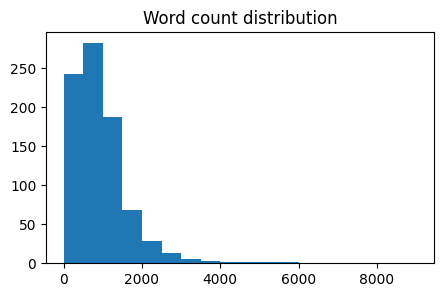

In [9]:
numOfWords=df.length
from matplotlib import pyplot as plt

fig=plt.figure(figsize=(5,3))
plt.hist(numOfWords.to_numpy(),bins=[0,500,1000,1500,2000,2500,3000,3500,4000,5000,6000,7000,8000,9000])
plt.title("Word count distribution")
plt.show()


In [12]:
tempDf=df[df.length<=900]
tempDf=tempDf[tempDf.length>=100]
tempDf.shape

(469, 4)

In [13]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained("allenai/led-base-16384")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
max_input_length = 1024
max_output_length = 1024
batch_size = 4

def process_data_to_model_inputs(batch):
    inputs = tokenizer(
        batch["summary"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )
    outputs = tokenizer(
        batch["content"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch["global_attention_mask"] = len(batch["input_ids"])*[
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch


In [16]:
import numpy as np
train, validate,test = np.split(tempDf.sample(frac=1,random_state=42),[int(.4*len(df)),int(.5*len(df))])
print(train.shape)
print(validate.shape)

(332, 4)
(83, 4)


In [17]:
train=train[0:250]
validate=validate[25:50]
print(train.shape,validate.shape)

(250, 4) (25, 4)


In [18]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)

In [19]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["content", "summary", "length", "__index_level_0__"]
)

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [20]:
val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["content", "summary", "length", "__index_level_0__"]
)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [21]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"]
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"]
)

In [24]:
from transformers import AutoModelForSeq2SeqLM
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

led.config.num_beams = 2
led.config.max_length = 1024
led.config.min_length = 512
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokent=True)
    labels_ids [labels_ids == -100]=  tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_takens=True)

    rouge_output = rouge.compute(
        predictions=pred_str,
        references=label_str,
        rouge_types=["rouge2"]
    )["rouge2"].mid
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4)
    }

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
transformers.logging.set_verbosity_info()


training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [25]:
trainer= Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [26]:
#trainer.train()

The following columns in the training set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 250
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 30
  Number of trainable parameters = 161,844,480
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,2.761400,2.540075,0.146300,0.152600,0.148100


The following columns in the evaluation set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 25
  Batch size = 4
Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 1024,
  "min_length": 512,
  "no_repeat_ngram_size": 3,
  "num_beams": 2,
  "pad_token_id": 1,
  "use_cache": false
}

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_

KeyboardInterrupt: 

In [28]:
sample = tempDf.sample(frac=0.005,random_state=12)
sample.shape

(2, 4)

In [34]:
sample=sample[['content','summary']]
sample['content']

,content
409,“Who is Nightingale for?”<|n|><|n|>It’s a ques...
329,You must have heard start-up founders talking ...


In [39]:
sample['summary'][329]

'You must have heard start-up founders talking about first mover advantage, which is a real thing. If you enter a market which has the opportunity with a product/service which can cater to a need, the chances are you will build a business out of it. A firm which will learn from the mistakes of the first mover, and replicate all the successful strategies and add it’s own strategies to it. '

In [41]:
from datasets import load_metric
pubmed_test=Dataset.from_pandas(sample)
import torch

from datasets import load_dataset,load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

tokenizer = LEDTokenizer.from_pretrained("/content/drive/MyDrive/checkpoint-10")
model= LEDForConditionalGeneration.from_pretrained("/content/drive/MyDrive/checkpoint-10").to("cuda").half()

def generate_answer(batch):
  inputs_dict = tokenizer(batch["summary"], padding="max_length",max_length=512,return_tensors="pt",truncation=True)
  input_ids=inputs_dict.input_ids.to("cuda")
  attention_mask=inputs_dict.attention_mask.to("cuda")
  global_attention_mask=torch.zeros_like(attention_mask)

  predicted_abstract_ids=model.generate(input_ids,attention_mask=attention_mask,global_attention_mask=global_attention_mask)
  batch["predicted_content"]=tokenizer.batch_decode(predicted_abstract_ids,skip_special_tokens=True)
  return batch
result=pubmed_test.map(generate_answer,batched=True,batch_size=2)

loading file vocab.json
loading file merges.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file tokenizer.json
loading configuration file /content/drive/MyDrive/checkpoint-10/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "id2label": {
    "0": 

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [45]:
result['content'][1]

'You must have heard start-up founders talking about first mover advantage, which is a real thing. If you enter a market which has the opportunity with a product/service which can cater to a need, the chances are you will build a business out of it. There are challenges, creating awareness, capturing customers, getting them hooked to your product, or just getting people to adopt the product/service. This can be gained via building a technology leadership or building a barrier to entry. You have to be careful of competition, cause competition will come.<|n|><|n|>The firms which try and capture the first mover advantage will always have to be vary of competition to enter the market and beat them to building a sustained-viable business. The fight to being the ‘First Mover Champion’ is real and scary.<|n|><|n|>Not only that, the second mover advantage in the truest sense is capturing the majority of the market after the first mover has created it.<|n|><|n|>Rarely do first movers create a m

In [43]:
result['predicted_content'][1]

'You must have heard start-up founders talking about first mover advantage, which is a real thing. If you enter a market which has the opportunity with a product/service which can cater to a need, the chances are you will build a business out of it. A firm which will learn from the mistakes of the first mout, and replicate all the successful strategies and add it’s own strategies to it. __________________________________________First Mover Advantage is the first step in building a business. It is the second step in the process of building the business. The first step is to learn from all the successes of the previous mover and replicate them. A company which will be able to replicate all those successful strategies, and add them to it”. __________The second step is the third step. The third step is building the firm. The fourth step is creating a firm which can build a firm out of a product or service. The last step is making the product/ service available to the customer. The second s